In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime
from pandas.tseries.offsets import DateOffset
import numpy as np

df = pd.read_csv(r"C:\Users\Bogdan\OneDrive - University of Warwick\Desktop\Projects\(GOV BONDS) Yield Curve Arbitrage\Data\Expected values of predictor variables (6 mo horizon - 31-12-2024)\Work\Personal Saving Rate - NOT STATIONARY\Data.csv")
name = "PSAVERT"
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index('DATE')
df = df.asfreq(pd.infer_freq(df.index))
last_value = df[name].iloc[-1]
df[name] = df[name].diff()
df=df.dropna()

result = adfuller(df[name])
p_value = result[1]
formatted_p_value = "{:.2f}".format(p_value) #int 2 deicimal places
print("p-value:", formatted_p_value)

p-value: 0.00


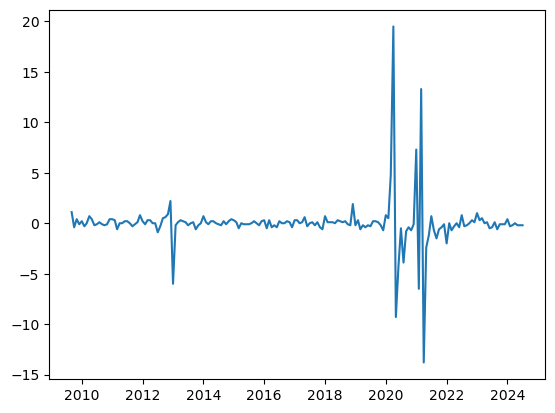

In [19]:
plt.plot(df)

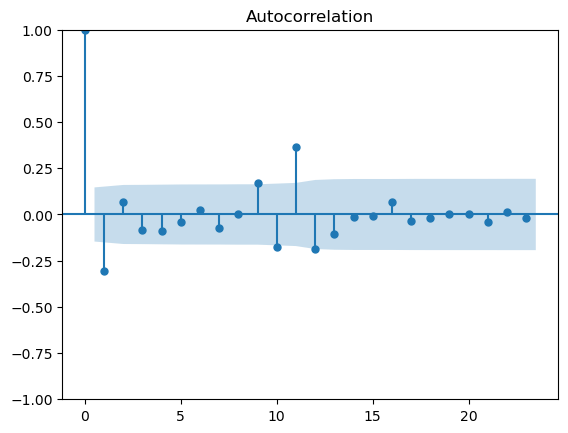

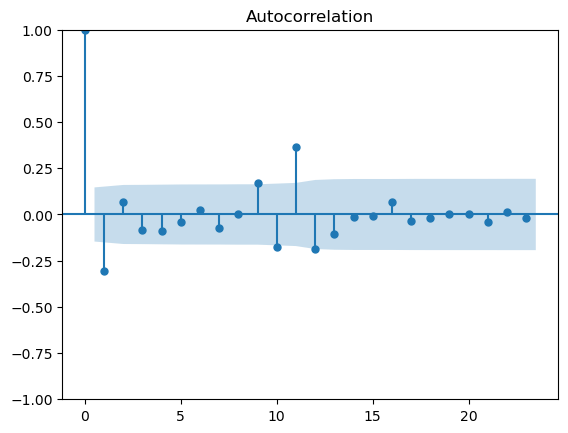

In [20]:
plot_acf(df[name])

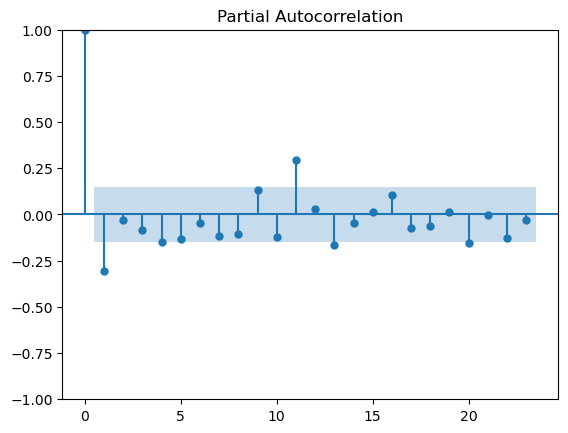

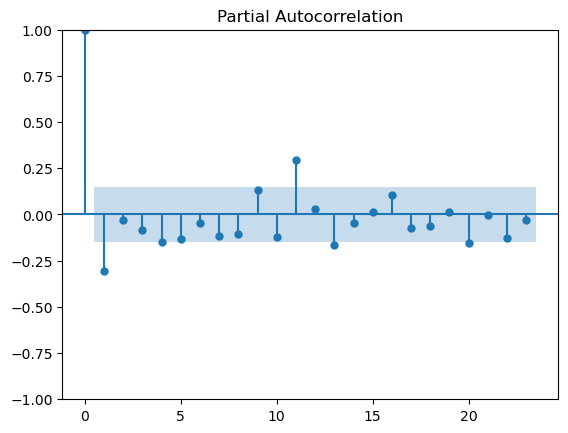

In [21]:
plot_pacf(df[name])

In [22]:
train_end = df.index[-6]

train_data = df[:train_end]
test_data = df[train_end:]

In [23]:
model = ARIMA(train_data, order=(1,1,1))
model_fit = model.fit()

In [24]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                PSAVERT   No. Observations:                  174
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -396.957
Date:                Sun, 01 Sep 2024   AIC                            799.914
Time:                        18:22:22   BIC                            809.374
Sample:                    09-01-2009   HQIC                           803.752
                         - 02-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3028      0.026    -11.599      0.000      -0.354      -0.252
ma.L1         -0.9998      0.947     -1.056      0.291      -2.855       0.856
sigma2         5.5734      5.154      1.081      0.2

In [25]:
predictions = model_fit.predict(start=test_data.index[0], end=test_data.index[-1])

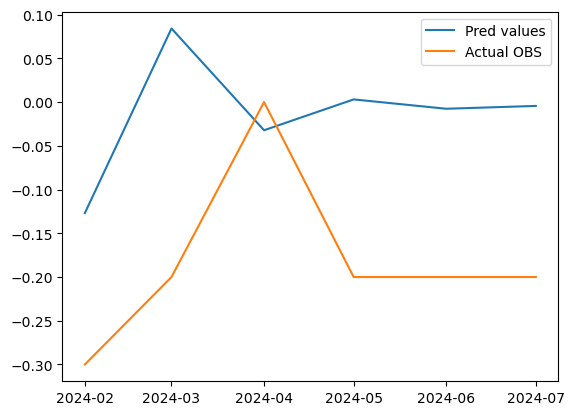

In [26]:
plt.plot(predictions, label = "Pred values")
plt.plot(test_data, label="Actual OBS")
plt.legend()

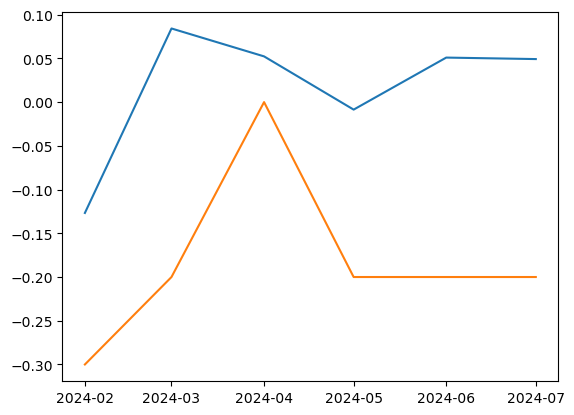

In [27]:
rolling_predictions = pd.Series(index=test_data.index) #initialise a series

for i in test_data.index:#give me the next week + timedelta(days=7)
    train_data = df[:i - DateOffset(months=1)]
    model = ARIMA(train_data, order=(1,1,1))
    model_fit = model.fit()
    pred = model_fit.forecast()
    rolling_predictions.loc[i] = pred

plt.plot(rolling_predictions, label='Pred values')
plt.plot(test_data, label='Actual OBS')

In [28]:
rolling_predictions = pd.DataFrame(rolling_predictions)
rolling_predictions.rename(columns={0: 'Predictions'}, inplace=True)
rolling_predictions

,Predictions
DATE,
2024-02-01,-0.126744
2024-03-01,0.084185
2024-04-01,0.052275
2024-05-01,-0.008588
2024-06-01,0.050907
2024-07-01,0.049201


In [29]:
test_data

,PSAVERT
DATE,
2024-02-01,-0.3
2024-03-01,-0.2
2024-04-01,0.0
2024-05-01,-0.2
2024-06-01,-0.2
2024-07-01,-0.2


In [30]:
residuals = test_data[name] - rolling_predictions['Predictions']
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 0.21416711621157042


c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Bogdan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be use

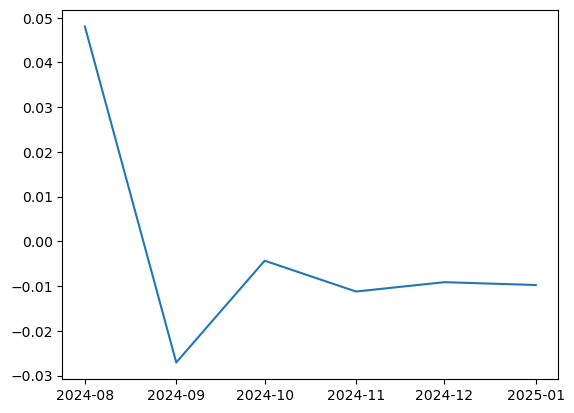

In [31]:
future_periods = 6  # e.g., predicting the next 6 months
future_dates = pd.date_range(start=df.index[-1] + DateOffset(months=1), periods=future_periods, freq='MS')
rolling_predictions = pd.Series(index=future_dates)

# Initialize the training data with the full df
train_data = df.copy()

# Iterate over each future period to make predictions
for i in range(future_periods):
    # Train the model on the current train_data
    model = ARIMA(train_data, order=(1, 1, 1))
    model_fit = model.fit()
    
    # Make the prediction for the next point
    pred = model_fit.forecast()
    
    # Determine the index of the new prediction
    next_index = train_data.index[-1] + DateOffset(months=1)
    
    # Append the prediction to the rolling_predictions and train_data
    rolling_predictions.loc[next_index] = pred
    train_data.loc[next_index] = pred  # this is adding the pred observation to the train data so as to consider it for the next prediction

plt.plot(rolling_predictions)


In [32]:
rolling_predictions

2024-08-01    0.048051
2024-09-01   -0.027074
2024-10-01   -0.004319
2024-11-01   -0.011210
2024-12-01   -0.009123
2025-01-01   -0.009755
Freq: MS, dtype: float64

In [33]:
df[name]

DATE
2009-09-01    1.1
2009-10-01   -0.4
2009-11-01    0.4
2009-12-01   -0.1
2010-01-01    0.2
             ... 
2024-03-01   -0.2
2024-04-01    0.0
2024-05-01   -0.2
2024-06-01   -0.2
2024-07-01   -0.2
Freq: MS, Name: PSAVERT, Length: 179, dtype: float64

In [34]:
predictions = np.array(rolling_predictions)
original_values = [last_value]    
for i in predictions:
    new_value = original_values[-1] + i
    original_values.append(new_value)
    
the_actual_predictions_I_need = np.array(original_values[1:])
the_actual_predictions_I_need[-1]

2.886569898275727